In [1]:
# TClass development?

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot
import matplotlib.tri 
import rdkit.Chem
import rdkit.Chem.AllChem
import mpl_toolkits.mplot3d
import stl
import operator
import functools
import os
import gif

from skspatial.objects import Point, Vector, Triangle

from scipy.constants import golden
from IPython.display import HTML

ModuleNotFoundError: No module named 'rdkit'

In [ ]:
import pixiedust

In [ ]:
# Constants
_unit_length = np.sqrt(1+(golden*golden))
# the two distances we need for the coordinates.
_c1 = 1 / _unit_length
_c2 = golden / _unit_length
# The points that make up an icosahedron in space, circumradius 1, centered around 0,0,0
_points = [
        Point([-_c1,  _c2,   0]),
        Point([ _c1,  _c2,   0]),
        Point([ _c1, -_c2,   0]),
        Point([-_c1, -_c2,   0]),
        Point([-_c2,   0, -_c1]),
        Point([ _c2,   0, -_c1]),
        Point([ _c2,   0,  _c1]),
        Point([-_c2,   0,  _c1]),
        Point([  0,  _c1, -_c2]),
        Point([  0,  _c1,  _c2]),
        Point([  0, -_c1,  _c2]),
        Point([  0, -_c1, -_c2])
        ]

_edges = [
    frozenset([0, 1]),
    frozenset([8, 1]),
    frozenset([5, 1]),                 
    frozenset([6, 1]),
    frozenset([9, 1]),                 
    frozenset([0, 8]),
    frozenset([8, 5]),                 
    frozenset([5, 6]),
    frozenset([6, 9]),                 
    frozenset([9, 0]),                 
    frozenset([0, 4]),
    frozenset([4, 8]),
    frozenset([8, 11]),                 
    frozenset([11, 5]),
    frozenset([5, 2]),                 
    frozenset([2, 6]),
    frozenset([6, 10]),                 
    frozenset([10, 9]),
    frozenset([9, 7]),                 
    frozenset([7, 0]),   
    frozenset([4, 11]),
    frozenset([11, 2]),
    frozenset([2, 10]),                 
    frozenset([10, 7]),
    frozenset([7, 4]),                 
    frozenset([4, 3]),
    frozenset([11, 3]),                 
    frozenset([2, 3]),
    frozenset([10, 3]),                 
    frozenset([7, 3]) 
]

# Used to make sure the ico will fit in a 3D render
_scale = np.array(_points).flatten('K')

# How high to draw triangles for 2D output
_triangle_2d_hypotenuse = 6
_triangle_2d_height = np.sqrt( _triangle_2d_hypotenuse**2 - (_triangle_2d_hypotenuse/2)**2)

In [3]:
class Molecule(object):
    """ Holds a molecule
    """
    
    # Load the standard colours and convert into the right format for matplotlib.
    _colour_frame = pd.read_csv(os.path.join("JMolColors-master","JMolColors-master","jmolcolors.csv"))
    _colour_list = {}
    for _,a in _colour_frame.iterrows():
        _colour_list[a['atom']] = (a['R'] / 255.0, a['G'] / 255.0, a['B'] / 255.0)
    # for reasons, override carbon and hydrogen
    _colour_list['C'] = (0.0, 0.0, 0.0)
    _colour_list['H'] = (0.0, 0.5, 0.5)
    
    @classmethod
    def get_atom_colour(cls, atom):
        """ Returns RGB color tuple corresponding to atom
        :param str atom: symbol for atom
        """
        return cls._colour_list[atom]
    
    @classmethod
    def get_atom_colour_list(cls, atom_list):
        """ Get a list of the corresponding colours for a list of atoms.
        """
        return [cls.get_atom_colour(a) for a in atom_list]
    
    @staticmethod
    def _atoms_from_mol_file(mol_file,no_of_atoms):
        """Grabs the atoms from a read in version of a molfile
        """
        chopped_mol=mol_file.split('\n')[4:]
        atom_list=[]
        for idx in range(no_of_atoms):
            line=chopped_mol[idx].split(' ')
            data=[x for x in line if not x =='']
            atom_list.append(data[3])
        return atom_list
    
    def _parse_conformer(self):
        self.coords = self.conformer.GetPositions()
        # now scale them to fit the sphere.
        coords_max = max(self.coords.flatten()) / 0.75
        self.coords /= coords_max
        self.coords_x = self.coords[:,0]
        self.coords_y = self.coords[:,1]
        self.coords_z = self.coords[:,2]
        
    
    def __init__(self,smiles_string):
        """ Factory method to build a molecule from a smiles string.
        """
        # Parse the molecule
        base_m = rdkit.Chem.MolFromSmiles(smiles_string)
        rdkit.Chem.AllChem.EmbedMolecule(base_m)
        # Add the hydrogens
        molecule = rdkit.Chem.AddHs(base_m)
        rdkit.Chem.AllChem.EmbedMolecule(molecule)
        # use MMFF94 to minimise and make a nice structure
        rdkit.Chem.AllChem.MMFFOptimizeMolecule(molecule)
        
        # get a conformer, any conformer and parse it.
        self.conformer = molecule.GetConformers()[0]
        self._parse_conformer()
        
        atom_count = self.conformer.GetNumAtoms()
        
        # get molefile
        mol_file=rdkit.Chem.MolToMolBlock(molecule)
        self.atom_list=Molecule._atoms_from_mol_file(mol_file, atom_count)
        self.colour_list = Molecule.get_atom_colour_list(self.atom_list)
        
        self.molecule = molecule
        self.smiles = smiles_string
    
    def draw3D(self, target):
        """ Draw the object in 3d
        """
        target.scatter(self.coords_x, self.coords_y, self.coords_z, self.colour_list)
    
    def __repr__(self):
        return repr("Molecule: {}".format(self.smiles))
        

NameError: name 'os' is not defined

In [4]:
class Face(object):
    """A class to define a face on an icosphere
    a,b,c are the points in 3D space of points on an icosphere
    u,v are the coordinates on a 2D plane corresponding to the unfolded icosphere net
    children are the faces at the next layer of magnification (anti coarse graining of a sphere)
    atoms are the atoms that project onto that face"""
    def __init__(self, a=None, b=None, c=None):
        self.a = Vector(a) # these are vectors from 0,0,0 to x y z etc
        self.b = Vector(b)
        self.c = Vector(c)
        self.triangle = Triangle(a,b,c)
        self.normal = self.triangle.normal()
        self.u = None
        self.v = None
        self.w = None
        self.children = []
        self.atoms = []
        

    def create_children(self, levels_to_do=1):
        """triangles are formed at the midpoints of edges
            we label points in a clockwise manner ALWAYS"""
        if self.children:
            # check we not got no children already
            raise ValueError("create children called on face with children already assigned")
        if levels_to_do == 0:
            return
        # ab is the left hand edge of the triangle
        # finds the mid-point on the line defined by x, y
        # AND PROEJCTS IT TO THE UNIT SPHERE EASY!
        ab = ((self.a + self.b) /2).unit()
        bc = ((self.b + self.c) /2).unit()
        ca = ((self.c + self.a) /2).unit()
        self.children = [ # the four new triangles
            Face(self.a, ab, ca), # 1 bottom left
            Face(ab, self.b, bc), # 2 top
            Face(ca, bc, self.c), # 3 bottom right
            Face(ab, bc, ca)] # 4 middle
        for child in self.children:
            # this should work...
            child.create_children(levels_to_do-1)

        def get_atom_for_point(self):
            pass
            return

    def get_mesh(self):
        """ Return the mesh for this face as an array.
        """
        if self.children:
            return functools.reduce(operator.add, [c.get_mesh() for c in self.children])
        
        # Leaf node
        return [[self.a, self.b, self.c]]
    
    def _get_colour(self):
        """ Pick the best colour to render self with
        """
        if not self.atoms:
            # Nothing to see here.
            return (1.0, 1.0, 1.0)
        
        if len(self.atoms) == 1:
            # Only one choice
            return Molecule.get_atom_colour(self.atoms[0])
        
        atom1 = [ a for a in self.atoms if a is not "H"]
        atom2 = [ a for a in atom1 if a is not "C"]
        
        if atom2:
            # Something more interesting than Carbon / Hydrogen. Pick the first
            return Molecule.get_atom_colour(atom2[0])
        if atom1:
            # Carbon at least
            return Molecule.get_atom_colour("C")
        # must have been multiple hydrogens
        return Molecule.get_atom_colour("H")
    
    def _draw(self, plot, u, v, w):
        """ Inner function for the drawing. Plots this face between the points shown.
            uvw need to be specified in clockwise order.
        """
        if not self.children:
            xs = np.array([x for x,_ in [u, v, w]])
            ys = np.array([y for _,y in [u, v, w]])
            tris = np.array([[0,1,2]])
            tri = matplotlib.tri.Triangulation(xs, ys, tris)
        
            x=matplotlib.pyplot.Polygon(np.array([u,v,w]), ec='k', closed=True, color=self._get_colour())
            plot.gca().add_patch(x)
        
            return
        
        ux, uy = u
        vx, vy = v
        wx, wy = w
        uv = ((ux + vx) / 2, (uy + vy) / 2)
        vw = ((vx + wx) / 2, (vy + wy) / 2)
        wu = ((wx + ux) / 2, (wy + uy) / 2)
        self.children[0]._draw(plot, u, uv, wu)
        self.children[1]._draw(plot, uv, v, vw)
        self.children[2]._draw(plot, wu, vw, w)
        self.children[3]._draw(plot, uv, vw, wu)
        
    def add_atom(self, location, atom):
        """ Add a specific atom to the face
        """
        self.atoms.append(atom)
        if not self.children:
            return
        best_child = None
        best_angle = None
        for child in self.children:
            angle = location.angle_between(child.normal)
            if best_child is None or angle < best_angle:
                best_child = child
                best_angle = angle
        best_child.add_atom(location, atom)
        

        

In [6]:
def rot_ar_x(radi):
    return  np.array([[1, 0, 0, 0],
                      [0, np.cos(radi), -np.sin(radi), 0],
                      [0, np.sin(radi), np.cos(radi), 0],
                     [0, 0, 0, 1]], dtype=np.double)
 
def rot_ar_y(radi):
    return  np.array([[np.cos(radi), 0, np.sin(radi), 0],
                      [0, 1, 0, 0],
                      [-np.sin(radi), 0, np.cos(radi), 0],
                     [0, 0, 0, 1]], dtype=np.double)
 
def rot_ar_z(radi):
    return  np.array([[np.cos(radi), -np.sin(radi), 0, 0],
                      [np.sin(radi), np.cos(radi), 0, 0],
                      [0, 0, 1, 0],
                     [0, 0, 0, 1]], dtype=np.double)

In [5]:
i = Ico(1)
m=Molecule('CC(C)Cc1ccc(cc1)C(C)C(=O)O')
i.add_molecule(m)
i.draw2D()

NameError: name 'Ico' is not defined

In [416]:
L_alanine_smiles='N[C@@H](C)C(=O)O'
D_alanine_smiles='N[C@H](C)C(=O)O'
cubane_smiles='C12C3C4C1C5C2C3C45'
tamiflu_smiles='CCC(CC)O[C@@H]1C=C(C[C@@H]([C@H]1NC(=O)C)N)C(=O)OCC.OP(=O)(O)O'


In [10]:
i = Ico(1)
m=Molecule(D_alanine_smiles)
i.add_molecule(m)
for tri in range(20):
    for point in range(3):
        i.draw2D(tri, point)
        matplotlib.pyplot.savefig("R_alanine_{}_{}.png".format(tri,point), dpi=300, bbox_inches='tight')
        matplotlib.pyplot.close()

NameError: name 'TopFace' is not defined

In [12]:
m=Molecule(L_alanine_smiles)
for i in range(4):
    ic = Ico(i)
    ic.add_molecule(m)
    ic.draw2D()
    matplotlib.pyplot.savefig("L_alanine_depth_{}.png".format(i), dpi=300, bbox_inches='tight')
    matplotlib.pyplot.close()

NameError: name 'Molecule' is not defined

In [8]:

tforms = {0: rot_ar_x, 1: rot_ar_y, 2: rot_ar_z}

In [434]:
m=Molecule(tamiflu_smiles)
#rdkit.chem.rdMolTransforms.TransformConformer(mol.GetConformer(0), tforms[0](2*np.pi/36)
@gif.frame
def do_frame(i,d):
    rdkit.Chem.rdMolTransforms.TransformConformer(m.conformer, tforms[1](2*np.pi/100))
    m._parse_conformer()
    i = Ico(d)
    i.add_molecule(m)
    i.draw2D()

for d in range(3):
    frames = []
    for i in range(100):
        frame = do_frame(i,d)
        frames.append(frame)

    gif.save(frames, "tamiflu_{}.gif".format(d), duration=50)

In [11]:
class TopFace(Face):
    """ A Face that exists at the top level of the icosahedron.
        Contains extra functions  that inner faces do not need.
    """
    def __init__(self, a_idx, b_idx, c_idx):
        super().__init__(_points[a_idx],_points[b_idx],_points[c_idx])
        self.edges = {
            (a_idx,b_idx),
            (b_idx,c_idx),
            (c_idx,a_idx)
        }
        self.indices = [a_idx, b_idx, c_idx]
        self.neighbours = []
        # Where in the 2D unwrapped grid to render this face
        self.grid_coords = None                        
        
    def get_edges(self):
        """ Returns a set of the edges that this face has.
        """
        return [frozenset(x) for x in self.edges]
    
    def get_point_indices(self):
        """ Returns a set of the point indices that this face has.
        """
        return self.indices
    
    def clear_grid(self):
        """ Clear the grid before a fresh unwrap."""
        self.grid_coords = None                

    def _set_grid_first_row(self, top_idx, column):
        """ Recurse along the top row of the grid, initialising them
        """
        if top_idx not in self.indices:
            raise ValueError("Invalid point index.")
            
        if self.grid_coords is not None:
            # we've come all the way around. Stop
            return        
        
        self.grid_coords = (0, column)
        # Now find the faces to update.
        # next point is the point adjacent to the top point on the edge shared with the next
        # face on the top row. It is also a point shared with the adjacent face on the second row
        next_point = [b for a,b in self.edges if a==top_idx][0]
        next_faces = [n for n in self.neighbours if next_point in n.indices]
        assert(len(next_faces)==2)
        for next_face in next_faces:
            if top_idx in next_face.indices:
                # This is the one at the top of the next column.
                next_face._set_grid_first_row(top_idx,column+1)
                continue
            
            # This is the one below us on the second row  
            assert(next_face.grid_coords is None)
            next_face.grid_coords = (1, column)
            
            # Find the one in the third row.
            third_face_candidates = [f for f in next_face.neighbours if (next_point in f.indices and f is not self)]
            assert(len(third_face_candidates)==1)
            third_face = third_face_candidates[0]
            assert(third_face.grid_coords is None)
            third_face.grid_coords = (2, column)
            
            # finally the fourth row.
            # two ways we could do it:
            # a. It is the neighbour of third_face that shares a point with next_face
            # b. It is the neighbour of third_face that is on the edge that does not contain next_point
            # Going with a.
            point_2_4 = [b for a,b in next_face.edges if a==next_point][0]
            fourth_face_candidates = [f for f in third_face.neighbours if (point_2_4 in f.indices and f is not next_face)]
            if( len(fourth_face_candidates) != 1):
                print("Third face neighbours:\n{}".format(third_face.neighbours))
                print("Second face:\n{}".format(next_face))
                print("Third face:\n{}".format(third_face))
                print("Second_fourth point: {}".format(point_2_4))
                print(fourth_face_candidates)
                
            assert(len(fourth_face_candidates)==1)
            fourth_face = fourth_face_candidates[0]
            assert(fourth_face.grid_coords is None)
            fourth_face.grid_coords = (3, column)                       
        
        
    def set_grid(self, top_idx):
        """ Initialise the grid, with the point marked as top_idx as the top point
            and self as 0,0
        """        
        self._set_grid_first_row(self.indices[top_idx], 0)
        
    def draw2D(self, plot, height=_triangle_2d_height, width=_triangle_2d_hypotenuse.):
        """
        Draw this face onto the supplied plot
        """
        if self.grid_coords is None:
            raise ValueError("draw2D called with no grid setup")
        
        y,x = self.grid_coords
        
        # Time to map from grid space to 2d space
        # If we are on an even numbered row, then we are facing up and our coords will be
        #    v
        #   / \
        #  u - w
        # If we are on an odd numbered row, then we are facing down and our coords will be
        #  u - v
        #   \ /
        #    w        
        
        # first u
        ux = (x +(y//2)/2)* width
        uy = (2 - y//2)*height
        self.u = (ux, uy)
        if y%2 == 0:
            # even row            
            self.v = (ux + (width/2.0), uy+height)
            self.w = (ux + width, uy)
        else:
            # odd row
            self.v = (ux + width, uy)
            self.w = (ux + (width/2.0), uy-height)
        self._draw(plot, self.u, self.v, self.w)
    

    def __repr__(self):
        """ Print the Face."""
        output = "Face: {}".format(self.indices)
        
        if self.grid_coords:
            output += " at {}".format(self.grid_coords)
            
        if self.u:
            output += " ({},{},{})".format(self.u, self.v, self.w)
            
        if self.atoms:
            output += " with {}".format(self.atoms)
        return repr(output)

SyntaxError: invalid syntax (<ipython-input-11-03d5bc95a271>, line 91)

In [9]:
class Ico(object):
    """A class to define an icsahedron or icosphere.
    """

    def __init__(self, level=0):
        """ Create a new icosphere.
        Level indicates how many subdivisions to make, 0 (default) will give you an icosohedron.
        All icospheres are centred around the origin with a cicumradius of 1
        """
        self.faces = [
                # Top row, around point 1
                TopFace(0, 1, 8),
                TopFace(8, 1, 5),
                TopFace(5, 1, 6),
                TopFace(6, 1, 9),
                TopFace(9, 1, 0),
                # Row 2
                TopFace(0, 8, 4),
                TopFace(8, 5, 11), 
                TopFace(5, 6, 2),
                TopFace(6, 9, 10), 
                TopFace(9, 0, 7),
                # Row 3
                TopFace(4, 8, 11), 
                TopFace(11, 5, 2), 
                TopFace(2, 6, 10), 
                TopFace(10, 9, 7), 
                TopFace(7, 0, 4),
                # Bottom row, around point 3
                TopFace(4, 11, 3), 
                TopFace(11, 2, 3),
                TopFace(2, 10, 3), 
                TopFace(10, 7, 3),
                TopFace(7, 4, 3)
                ]
        
        # Now create a dictionary of which faces have which edge and
        # one of which faces have which point
        self.edge_mappings = {}
        self.point_mappings = {}
        for face in self.faces:
            for edge in face.get_edges():
                try:
                    self.edge_mappings[edge].append(face)
                except KeyError:
                    self.edge_mappings[edge] = [face]
            for idx in face.get_point_indices():
                try:
                    self.point_mappings[idx].append(face)
                except KeyError:
                    self.point_mappings[idx] = [face]
        
        
        # Use this to tell each face what its neighbours are
        for idx in self.edge_mappings:
            if len(self.edge_mappings[idx]) != 2:
                print("{}:{}".format(idx, self.edge_mappings[idx]))
            assert(len(self.edge_mappings[idx])==2)
            l,r = self.edge_mappings[idx]
            l.neighbours.append(r)
            r.neighbours.append(l)
            

        # now perform the subdivisions
        # conditional isn't needed, but why waste the time?
        if level==0:
            return

        for face in self.faces:
            face.create_children(level)
    
    def get_mesh(self):
        """ return the mesh for this object
        """
        return functools.reduce(operator.add, [f.get_mesh() for f in self.faces])
    
    def _draw_init(self):
        self._figure = matplotlib.pyplot.figure()
        self._axes = mpl_toolkits.mplot3d.Axes3D(self._figure)
        self._mesh = i3.get_mesh()

    def _draw_3d(self, a, b):
        """Draw a single 3d frame
            a,b : angles to rotate the view by
        """
        # Load the stuff
        self._axes.add_collection3d(mpl_toolkits.mplot3d.art3d.Line3DCollection(self._mesh))
        self._axes.auto_scale_xyz(scale, scale, scale*1.25)
        self._axes.view_init(a,b) 
        matplotlib.pyplot.draw()
    
    def draw3D(self, a=15, b=30):
        """Quick function to draw a single frame
        """
        self._draw_init()
        self._draw_3d(a,b)
        
    def draw2D(self, first_face=0, point_idx=0):
        """Unwrap the ico and draw it, starting with the specified face, with the demarked point up
        """
        # Make sure the request makes sense.
        if first_face < 0 or first_face >= 20 or point_idx < 0 or point_idx >= 3:
            raise ValueError("Face needs to be in range 0..20, point 0..2")
            
        # clear any grid from previous runs        
        for f in self.faces:
            f.clear_grid()
        
        self.faces[first_face].set_grid(point_idx)
        
        # set up the image
        figure = matplotlib.pyplot.figure()
        matplotlib.pyplot.axis('equal')
        #matplotlib.pyplot.axis('off')
        
        for f in self.faces:
            f.draw2D(figure)
        matplotlib.pyplot.autoscale(enable=True, axis='both')

        matplotlib.pyplot.draw()
    
    def _add_atom(self, location, atom):
        best_face = None
        best_angle = None
        for face in self.faces:
            angle = location.angle_between(face.normal)
            if best_face is None or angle < best_angle:
                best_face = face
                best_angle = angle
        best_face.add_atom(location, atom)
    
    def add_molecule(self, molecule):
        """ Add a molecule to the ico, marking each face nearest each atom
        """
        for location, atom in zip(molecule.coords, molecule.atom_list):
            self._add_atom(Vector(location),atom)
        

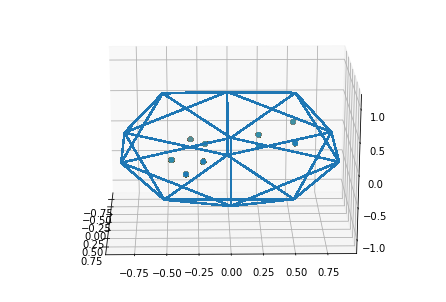

In [233]:
scale = np.array(_points).flatten('K')
figure = matplotlib.pyplot.figure()
axes = mpl_toolkits.mplot3d.Axes3D(figure)
mesh = i.get_mesh()

def draw(a,b):
    # Load the stuff
    m.draw3D(axes)
    axes.add_collection3d(mpl_toolkits.mplot3d.art3d.Line3DCollection(mesh))
    axes.auto_scale_xyz(scale, scale, scale*1.25)
    axes.view_init(a,b) 
    matplotlib.pyplot.draw()

#m.draw3D(axes)
#draw(12,15)
    
def frame(i):
    draw(20,i)
from matplotlib import animation, rc
video=animation.FuncAnimation(figure, frame,frames=360, interval=20).to_html5_video()
HTML(video)